In [3]:
import pandas as pd;

In [4]:
df = pd.read_csv('../data/subdataset_Biro_Daniel.csv')

In [5]:
# dropping columns with too many missing values

df = df.drop(columns=['PoolQC', 'Fence', 'MiscFeature'])

In [6]:
df.isna().sum()

WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
dtype: int64

In [7]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    print(col, df[col].nunique())

SaleType 9
SaleCondition 6


In [8]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [9]:
df.head()

,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,250,0,0,0,0,0,0,6,2010,145000,...,False,False,False,False,True,False,False,False,True,False
1,0,40,0,0,0,0,0,5,2009,178000,...,False,False,False,False,True,False,False,False,True,False
2,328,0,164,0,0,0,0,5,2008,85000,...,False,False,False,False,True,False,False,False,True,False
3,0,0,264,0,0,0,0,6,2007,175000,...,False,False,False,False,True,False,False,False,True,False
4,0,0,242,0,0,0,0,5,2010,127000,...,False,False,False,False,True,False,False,False,True,False


In [10]:
corr = df.corr()['SalePrice'].sort_values(ascending=False)
print(corr)

SalePrice                1.000000
SaleCondition_Partial    0.342705
SaleType_New             0.342149
WoodDeckSF               0.329843
OpenPorchSF              0.299969
ScreenPorch              0.119172
PoolArea                 0.115630
3SsnPorch                0.051532
SaleType_Con             0.047276
MoSold                   0.041890
SaleCondition_Alloca     0.023632
SaleType_CWD             0.022132
YrSold                  -0.009099
SaleType_ConLw          -0.012764
MiscVal                 -0.020179
SaleType_Oth            -0.025964
SaleType_ConLI          -0.033353
SaleType_ConLD          -0.035414
SaleCondition_Family    -0.048953
SaleCondition_AdjLand   -0.058686
EnclosedPorch           -0.149532
SaleCondition_Normal    -0.162234
SaleType_WD             -0.219436
Name: SalePrice, dtype: float64


In [11]:
selected_features = corr[abs(corr) > 0.2].index.tolist()

In [12]:
from sklearn.model_selection import train_test_split
X = df[selected_features].drop(columns=['SalePrice'])
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 59492.02150799182
Mean Squared Error: 7285209220.047006
R^2 Score: -0.1270765972993564


**Conclusion**

As there were no columns that were comparable to `SalePrice`, I had to choose the best whose correlation was above just 0.2. This explains the low performance of the model - only 12% of the variance in `SalePrice` could be explained by the selected features.

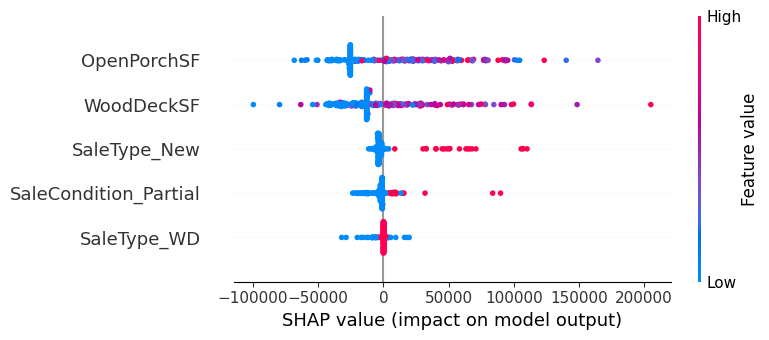

In [15]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.show()

The columns are ordered by importance. The SHAP value show how much each feature contributed to the prediction. OpenPorchSF and WoodDeckSF have the highest impact on the model output - each lowering the predicted price. Red means higher, blue means lower prices - this can be seen on the x-axis.